In this notebook we are going to look through the data we are given from the other groups! (Shoutout to Davon and company)
This script isn't going to be concerned with how data is collected from marta but simply reads a JSON of one ping.

I have provided two files:

In [9]:
import os
from datetime import datetime
from dateutil import parser
import datetime
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing

cwd = os.getcwd()
print(os.listdir(cwd))

['.git', '.ipynb_checkpoints', 'busExample.json', 'busList.json', 'Feature Selection and Creation.ipynb', 'marta.json', 'README.md']


Here we are going to visualize the two files that we have to better understand what data we are recieving and how to utilize this information

In [10]:
import json
from pprint import pprint

with open('marta.json') as f:
    busExample = json.load(f)

For ease of visualization I am going to just print one bus' data for one time

In [11]:
instance = busExample[0]
pprint(instance)

{'ADHERENCE': '0',
 'BLOCKID': '224',
 'BLOCK_ABBR': '196-2',
 'DIRECTION': 'Northbound',
 'LATITUDE': '33.6500981',
 'LONGITUDE': '-84.4482871',
 'MSGTIME': '3/9/2019 11:58:19 AM',
 'ROUTE': '196',
 'STOPID': '166900',
 'TIMEPOINT': 'College Pk Station (South Loop)',
 'TRIPID': '6604719',
 'VEHICLE': '1714'}


In [12]:
# just game out an idea in this block of what you would like for your vector you can implement this later if you wish!

features = []

Finally we are going to parse through the bigger file and store information about different buses:
Here we are going to find the dict of (vehicle, jsonList)

In [13]:
with open('marta.json') as f:
    busExample = json.load(f)

busDict = dict()

for entry in busExample:
    vehicle = entry['VEHICLE']
    if vehicle in busDict:
        temp = busDict[vehicle]
        temp.append(entry)
        busDict[vehicle] = temp
    else:
        busDict[vehicle] = [entry]

Here we are going to find the dict of (route, jsonList)

In [14]:
routeDict = dict()

for entry in busExample:
    route= entry['ROUTE']
    if route in routeDict:
        temp = routeDict[route]
        temp.append(entry)
        routeDict[route] = temp
    else:
        temp = []
        temp.append(entry)
        routeDict[route] = temp

In [15]:
dt = parser.parse(instance['MSGTIME'])
print(dt.date())
print(dt.time())

2019-03-09
11:58:19


In [16]:
import json

def build_data_struct(json_input):
    
    with open(json_input) as f:
        dictList = json.load(f)
        
    dayDict = dict()
    
    for entry in dictList:
        vehicle = entry['VEHICLE']
        dt = parser.parse(entry['MSGTIME'])
        date = dt.date()
        if date in dayDict:
            if vehicle in dayDict[date]:
                temp = dayDict[date][vehicle]
                temp.append(entry)
                dayDict[date][vehicle] = temp
            else:
                dayDict[date][vehicle] = [entry]
        else:
            temp = dict()
            temp[vehicle] = [entry]
            dayDict[date] = temp
            
    for date in dayDict.keys():
        vehicleDict = dayDict[date]
        for veh in vehicleDict.keys():
            vehicle = vehicleDict[veh]
            times = set()
            ls = []
            for ping in vehicle:
                if ping['MSGTIME'] not in times:
                    times.add(ping['MSGTIME'])
                    ls.append(ping)
            newlist = sorted(ls, key=lambda k: toTime(k['MSGTIME']))
            dayDict[date][veh] = newlist
    return dayDict

def toTime(name):
    dt = parser.parse(name)
    return dt.time()

In [31]:
dayDict = build_data_struct('marta.json')

In [ ]:
#pprint(dayDict.keys())
#pprint(dayDict[dt.date()])

In [49]:
from math import sin, cos, sqrt, atan2, radians

def distance (lon1, lat1, lon2, lat2):
    R = 6373.0
    # finding the value we are predicting
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dist = R * c / 1.61
    return dist

In [50]:
from math import sin, cos, sqrt, atan2, radians

def velocity (ping, nextPing):
    R = 6373.0
    # finding the value we are predicting
    last_time = parser.parse(ping['MSGTIME'])
    time = parser.parse(nextPing['MSGTIME'])
    delta_time = time - last_time
    
    lon1 = float(nextPing['LONGITUDE'])
    lat1 = float(nextPing['LATITUDE'])
    lon2 = float(ping['LONGITUDE'])
    lat2 = float(ping['LATITUDE'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dist = R * c / 1.61
    
    v = dist / delta_time.total_seconds() * 3600
    return v

In [58]:
def K_previous_vel (all_bus_data, day, vid, time, k):
    
    bus_data = all_bus_data[day][vid]
    target_i = 0 # which ping are we looking at
    
    for i, elem in enumerate(bus_data):
        datetime = parser.parse(elem['MSGTIME'])
        if datetime.time() == time:
            target_i = i
            break
    
    if k > target_i:
        return -1
        
    relevant_bus_data = bus_data[target_i - k: target_i]
    v_list = []
    
    last_lon = float(relevant_bus_data[0]['LONGITUDE'])
    last_lat = float(relevant_bus_data[0]['LATITUDE'])
    last_time = parser.parse(relevant_bus_data[0]['MSGTIME'])
    
    for elem in (relevant_bus_data[1:] + [bus_data[target_i]]):
        
        lon = float(elem['LONGITUDE'])
        lat = float(elem['LATITUDE'])
        dist = distance(last_lon, last_lat, lon , lat)
        
        #print("distance (miles))")
        #print(dist)
        
        
        last_lon = lon
        last_lat = lat
        time = parser.parse(elem['MSGTIME'])
        delta_time = time - last_time
        last_time = time
        
        
        time_hours = delta_time.total_seconds() / 3600
        #print("time (hrs)")
        #print(time_hours)
        
        v = dist / time_hours
        v_list.append(v)
        #print()
        
    return v_list

In [52]:
dt = parser.parse('3/9/2019 2:07:44 PM')
date = dt.date()
time = dt.time()

print(time)

14:07:44


In [53]:
pprint(dayDict[date]['1584'])

[{'ADHERENCE': '-7',
  'BLOCKID': '276',
  'BLOCK_ABBR': '26-4',
  'DIRECTION': 'Westbound',
  'LATITUDE': '33.8105614',
  'LONGITUDE': '-84.4775536',
  'MSGTIME': '3/9/2019 11:34:25 AM',
  'ROUTE': '26',
  'STOPID': '902136',
  'TIMEPOINT': 'Perry Blvd @ MARTA',
  'TRIPID': '6569667',
  'VEHICLE': '1584'},
 {'ADHERENCE': '-1',
  'BLOCKID': '276',
  'BLOCK_ABBR': '26-4',
  'DIRECTION': 'Eastbound',
  'LATITUDE': '33.7993459',
  'LONGITUDE': '-84.4613783',
  'MSGTIME': '3/9/2019 12:06:59 PM',
  'ROUTE': '26',
  'STOPID': '902292',
  'TIMEPOINT': 'Ajax Dr & Abner Terr',
  'TRIPID': '6575431',
  'VEHICLE': '1584'},
 {'ADHERENCE': '-2',
  'BLOCKID': '276',
  'BLOCK_ABBR': '26-4',
  'DIRECTION': 'Eastbound',
  'LATITUDE': '33.790193',
  'LONGITUDE': '-84.4403526',
  'MSGTIME': '3/9/2019 12:15:10 PM',
  'ROUTE': '26',
  'STOPID': '902019',
  'TIMEPOINT': 'Perry Blvd @ MARTA',
  'TRIPID': '6575431',
  'VEHICLE': '1584'},
 {'ADHERENCE': '-4',
  'BLOCKID': '276',
  'BLOCK_ABBR': '26-4',
  'DIRE

In [64]:
ls = K_previous_vel(dayDict, date, '1584', time, 4)
print(ls)

[24.576771600515062, 0.671914715229367, 34.037131394661984, 2.0320450719825374]


alrightyyyyy its the time weve all been waiting fooooooor, getting all of the training data in the right format

since we need to avoid using previous velocities being fed into to predict themselves I think we should try to use one day's training data (what I'm going to call the data from marta.json) and another day as testing data

In [56]:
def makeXandy (filename, k):
    
    data_struct = build_data_struct(filename)
    
    
    lenFeatures = 0
    X = pd.DataFrame(np.zeros((1,k +  6 + lenFeatures)))
    y = []
    
    counter = 0
    
    for day in data_struct.keys():
        dayDict = data_struct[day]
        for veh in dayDict.keys():
            
            pingList = dayDict[veh]
            
            for i in range(k, (len(pingList) -1)):
                ping = pingList[i]
                dt = parser.parse(ping['MSGTIME'])
                ls = K_previous_vel(data_struct, dt.date(), veh, dt.time(), k)
                if len(ls) == k:
                    
                    
                    # adding new features (we could do whatever we want here)
                    ls.append(ping["ROUTE"])
                    ls.append(ping["TIMEPOINT"])
                    ls.append(float(ping["LATITUDE"]))
                    ls.append(float(ping["LONGITUDE"]))
                    ls.append(ping["VEHICLE"])
                    ls.append(ping["BLOCKID"])
                    
                    #we can add even more features if you wanted, put them in features
                    features = []
                    ls = ls + features
                    
                    
                    # finding the value we are predicting
                    nextPing = pingList[i+1]
                    last_time = parser.parse(ping['MSGTIME'])
                    time = parser.parse(nextPing['MSGTIME'])
                    delta_time = time - last_time
                    last_lon = float(nextPing['LONGITUDE'])
                    last_lat = float(nextPing['LATITUDE'])
                    lon = float(ping['LONGITUDE'])
                    lat = float(ping['LATITUDE'])
                    
                    dist = distance(last_lon, last_lat, lon,lat)
                    
                    v = dist / delta_time.total_seconds() * 3600
                    
                    X.loc[counter] = ls
                    y.append(v)
                    counter = counter + 1
    
    
    #here we map down to numbers because I am lazy this could def be better 
    
    d = generateMap(X,5)
    X.iloc[:,5] = [d[item] for item in X.iloc[:,5]] 
    
    d = generateMap(X,6)
    X.iloc[:,6] = [d[item] for item in X.iloc[:,6]] 
    
    d = generateMap(X,9)
    X.iloc[:,9] = [d[item] for item in X.iloc[:,9]] 
    
    d = generateMap(X,10)
    X.iloc[:,10] = [d[item] for item in X.iloc[:,10]] 
    
    
    y = pd.Series(y)
    return [X,y]





def generateMap(X,index):
    ls = X.iloc[:,index]
    d = dict()
    counter = 1
    
    for l in ls:
        if l not in d:
            d[l] = counter
            counter = counter + 1
    return d

In [59]:
[X,y] = makeXandy("marta.json",5)
X = preprocessing.normalize(X)

In [60]:
print(X)
print(y)

[[ 0.08230408  0.06726303  0.0845397  ... -0.91616603  0.0108546
   0.0108546 ]
 [ 0.06465422  0.08126082  0.06166184 ... -0.88030268  0.01043361
   0.01043361]
 [ 0.08126857  0.06166773  0.06687944 ... -0.880159    0.0104346
   0.0104346 ]
 ...
 [ 0.03799799  0.02535049  0.02507486 ... -0.18574048  0.61195519
   0.60975392]
 [ 0.02539128  0.0251152   0.03772844 ... -0.18606565  0.61293985
   0.61073503]
 [ 0.02514048  0.0377664   0.05968176 ... -0.18626904  0.61355665
   0.61134961]]
0       27.536236
1        5.942236
2        4.893071
3        5.087603
4       19.473401
5        7.889203
6        8.107465
7       90.588582
8       11.820236
9        2.572309
10       4.321779
11      14.695143
12       8.770717
13      53.908317
14       4.645393
15      10.645778
16       4.382572
17       0.739086
18       9.428656
19       8.828539
20      20.075322
21      22.993570
22       1.955450
23       1.921165
24       8.477824
25       6.973214
26      12.848104
27      54.035048
28    

Okay I have given you guys X and y just as I described. If you wish to add some value do it to features and if you wish to include more previous velocities go on ahead. I need to run this code again to get our training data but that is soon to come. In the meantime enjoy some sexy looking plots with the data.
Note that I use a LOT of libraries in the following block (youre gonna need to pip install #### most of them)

In [61]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
from sklearn import preprocessing


def pca (X, y, num_components):
    X = preprocessing.normalize(X)
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(X)
    plt.plot(range(num_components), pca.explained_variance_ratio_)
    plt.plot(range(num_components), np.cumsum(pca.explained_variance_ratio_))
    plt.title("Component-wise and Cumulative Explained Variance")
    plt.show()

    svd = TruncatedSVD(n_components = 3,random_state=42).fit_transform(X)
    
    maxVal = 0
    for val in y:
        maxVal = max(maxVal, val)
    
    color = [(item/maxVal) for item in y]
    
    plt.figure(figsize=(12,8))
    plt.title('PCA')
    plt.scatter(x = svd[:,0], y = svd[:,1], c = color, s = 10, cmap = 'ocean')
    plt.xlabel("1st Component")
    plt.ylabel("2nd Component")
    plt.show()
    
    
    
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(xs = svd[:,0], ys = svd[:,1], zs = svd[:,2], c = color,s = 10,cmap = 'ocean')
    plt.title('PCA')
    ax.set_xlabel('1st Component')
    ax.set_ylabel('2nd Component')
    ax.set_zlabel('3rd Component')

    plt.show()


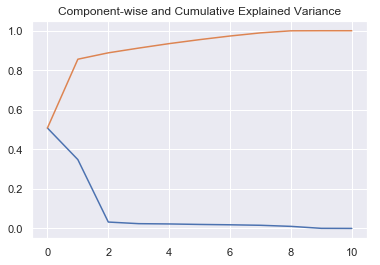

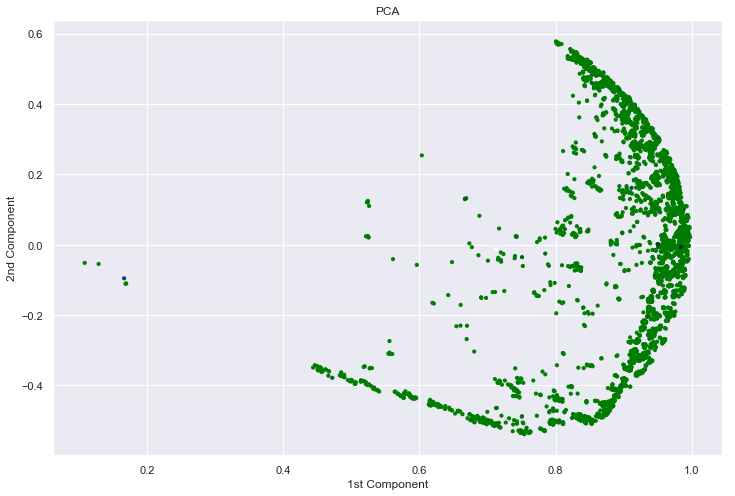

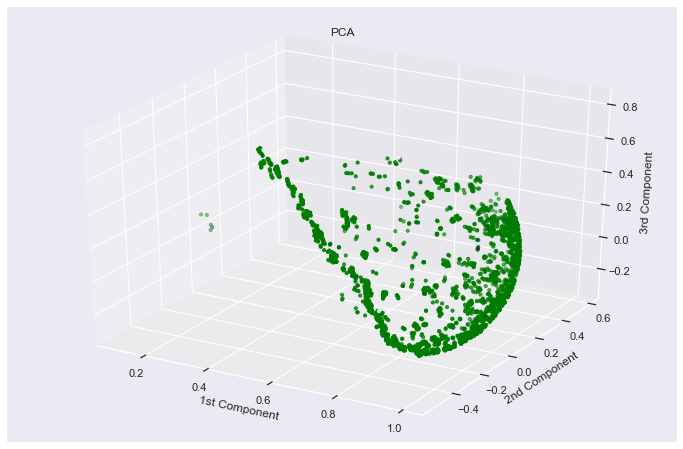

In [62]:
pca(X,y,X.shape[1])

In [63]:
from sklearn import 

SyntaxError: invalid syntax (<ipython-input-63-f092e4b16e8b>, line 1)